In [1]:
import hoomd
import numpy as np

from monk import prep, pair

In [2]:
init_temp=0.45
dt = 1e-2

In [3]:
seed = 100
print("Initialize HOOMD simulation")
device = hoomd.device.auto_select()
sim = hoomd.Simulation(device=device, seed=seed)
print(f"Running on {device.devices[0]}")

Initialize HOOMD simulation
Running on CPU


In [4]:
sim.create_state_from_gsd("/home/ian/Documents/Data/monk/pre_softness_fire/run1/pair-KA_LJ_phi-1.2/temp-0.45_seed-0.gsd")

integrator = hoomd.md.Integrator(dt=dt)
cell = hoomd.md.nlist.Cell()
lj = pair.KA_LJ(cell)
integrator.forces.append(lj)


In [5]:
nvt = hoomd.md.methods.NVT(
    kT=init_temp,
    filter=hoomd.filter.All(),
    tau=0.5)
integrator.methods.append(nvt)
sim.operations.integrator = integrator

sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=init_temp)

In [6]:
# Custom hoomd triggers and actions

class AsyncTrigger(hoomd.trigger.Trigger):
    """NOT async in the Rust or JavaScript way
    
    Trigger by calling the activate() method"""

    def __init__(self):
        self.async_trig = False
        hoomd.trigger.Trigger.__init__(self)

    def activate(self):
        self.async_trig = True

    def compute(self, timestep):
        out = self.async_trig
        self.async_trig = False
        return out

class RestartablePeriodicTrigger(hoomd.trigger.Trigger):

    def __init__(self, period):
        assert(period >= 1)
        self.period = period
        self.state = period - 1
        hoomd.trigger.Trigger.__init__(self)

    def reset(self):
        self.state = self.period - 1

    def compute(self, timestep):
        if self.state >= self.period - 1:
            self.state = 0
            return True
        else:
            self.state += 1
            return False


class UpdatePos(hoomd.custom.Action):
    """Custom action to handle feeding in a new set of positions through a snapshot"""

    def __init__(self, new_snap=None):
        self.new_snap = new_snap

    def set_snap(self, new_snap):
        self.new_snap = new_snap

    def act(self, timestep):
        old_snap = self._state.get_snapshot()
        if old_snap.communicator.rank == 0:
            N = old_snap.particles.N
            new_velocity = np.zeros((N,3))
            for i in range(N):
                old_snap.particles.velocity[i] = new_velocity[i]
                old_snap.particles.position[i] = self.new_snap.particles.position[i]
        self._state.set_snapshot(old_snap)

class PastSnapshotsBuffer(hoomd.custom.Action):
    """Custom action to hold onto past simulation snapshots"""

    def __init__(self):
        self.snap_buffer = []

    def clear(self):
        self.snap_buffer.clear()

    def get_snapshots(self):
        return self.snap_buffer

    def force_push(self):
        self.act(None)

    def act(self, timestep):
        snap = self._state.get_snapshot()
        self.snap_buffer.append(snap)


In [7]:
snap = sim._state.get_snapshot()

In [8]:
from schmeud.dynamics import thermal
import pandas as pd

In [9]:
replicas = 1000
steps_per_dump = 10
total_steps = 1000

In [10]:

custom_updater = UpdatePos(new_snap=snap)
snap_buffer = PastSnapshotsBuffer()
reset_config_trig = AsyncTrigger()
snap_buffer_trig = RestartablePeriodicTrigger(steps_per_dump)

custom_op = hoomd.update.CustomUpdater(action=custom_updater,
                                       trigger=reset_config_trig)

another_op = hoomd.update.CustomUpdater(action=snap_buffer,
                                        trigger=snap_buffer_trig)

In [11]:
sim.operations.add(custom_op)
sim.operations.add(another_op)

In [12]:
temps = [0.65, 0.6, 0.55, 0.5, 0.45]

In [20]:
sim.run(0)

In [18]:
all_phops = []

for temp in temps:

    nvt.kT = temp

    # iterate over traj frames
    for idx in range(replicas):
        # if idx%100 == 0:
        #     print("Frame", jdx, "\n--> Replica", idx)
        reset_config_trig.activate()
        snap_buffer_trig.reset()
        sim.run(2)
        nvt.thermalize_thermostat_dof()

        


        sim.run(total_steps+2)

        # process phop
        mtraj = snap_buffer.get_snapshots()
        phop = thermal.calc_phop(mtraj, tr_frames=len(mtraj)-1)

        all_phops.append([np.float32(temp), np.arange(len(phop[0]), dtype=np.uint16), np.uint16(idx), phop[0].astype(np.float32)]) # trivial unwrapping

        snap_buffer.clear()

df = pd.DataFrame(all_phops, columns=["temp", "id", "replica", "phop"]).explode(["id", "phop"])

**ERROR**: Particle with unique tag 987 is no longer in the simulation box.

Cartesian coordinates: 
x: -56.0423 y: -82.9137 z: -3.66168
Fractional coordinates: 
f.x: -3.22212 f.y: -5.00681 f.z: 0.256805
Local box lo: (-7.52829, -7.52829, -7.52829)
          hi: (7.52829, 7.52829, 7.52829)


RuntimeError: Error computing cell list

In [19]:
len(all_phops)

166

In [81]:
df.head()

,temp,id,replica,phop
0,0.7,0,0,0.103403
0,0.7,1,0,0.202587
0,0.7,2,0,0.044455
0,0.7,3,0,0.319579
0,0.7,4,0,0.231451


In [75]:
tdf = df[df.id == 2]

In [76]:
fdf = tdf.groupby("temp").apply(lambda df: df.phop.mean())


In [77]:
import matplotlib.pyplot as plt

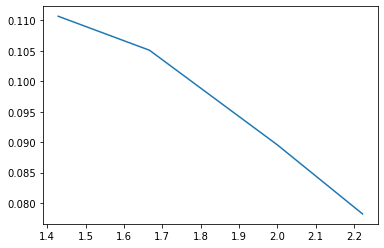

In [78]:
plt.plot(1/fdf.index, fdf.values)

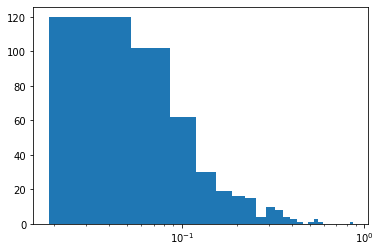

In [71]:
plt.hist(tdf.phop, bins=25)
plt.xscale('log')

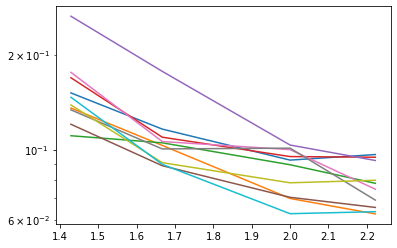

In [80]:
for id in range(10):
    tdf = df[df.id == id]
    fdf = tdf.groupby("temp").apply(lambda df: df.phop.mean())
    plt.plot(1/fdf.index, fdf.values)
plt.yscale('log')

In [83]:
def rearrange(df):
    N = len(df)
    tmp = df[df.phop > 0.2]
    return len(tmp)/N

In [85]:
tmp = df.groupby(["temp", "id"]).apply(rearrange)

In [93]:
bins = np.logspace(-2, 0, 10, base=10)

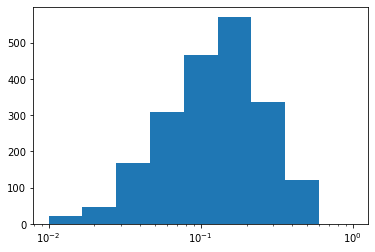

In [94]:
plt.hist(tmp, bins=bins)
plt.xscale('log')

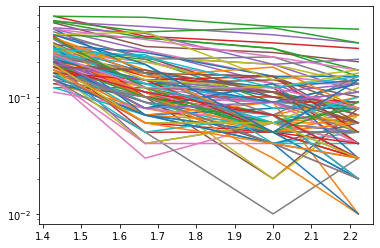

In [113]:
for idx, _df in tmp.groupby("id"):
    inv_temp = [1/t[0] for t in _df.index]
    plt.plot(inv_temp, _df.values)
    if idx > 100:
        break

plt.yscale('log')